In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from scipy.stats import kendalltau
from scipy.stats import spearmanr

In [2]:
df_transactions_wofirstname = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/Rohdaten/" +
                                    "ELPHI_transactions_ohne_vorname.csv")

df_history_wofirstname = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/Rohdaten/" +
                                    "ELPHI_history_ohne_vorname.csv")

C:\Users\felix.oechslein\AppData\Local\Temp\ipykernel_8528\3453601399.py:1: DtypeWarning: Columns (13,15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_transactions_wofirstname = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/Rohdaten/" +


In [3]:
df_privatkunden_iids = pd.read_csv("C:/Users/felix.oechslein/Desktop/Daten, 13.12.22/" +
                                    "privatkunden.iid.ELPHI.csv", index_col = [0])

# 1. Daten bereinigen

#### 1.1 Transaktions-Daten bereinigen

In [4]:
df_t_bereinigt = df_transactions_wofirstname[["iid", "key", "attrtype", "status", "pricetotal", "createdprovider"]]
df_t_bereinigt["pricetotal"] = pd.to_numeric(df_t_bereinigt["pricetotal"], errors = "coerce")
df_t_bereinigt = df_t_bereinigt.query('attrtype == "TI"')
df_t_bereinigt = df_t_bereinigt.query('status == "Buchung" or status == "Order"')
df_t_bereinigt = df_t_bereinigt.query('pricetotal >= 0.01')
searchfor = ['TEST']
#searchfor = ['TEST', 'JET', "WS"]
df_t_bereinigt = df_t_bereinigt[~df_t_bereinigt["key"].str.contains('|'.join(searchfor))]
df_t_bereinigt.head()

C:\Users\felix.oechslein\AppData\Local\Temp\ipykernel_8528\687719975.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t_bereinigt["pricetotal"] = pd.to_numeric(df_t_bereinigt["pricetotal"], errors = "coerce")


,iid,key,attrtype,status,pricetotal,createdprovider
2,278172159,JET_1_a1516015,TI,Order,48.0,20221011174600
3,278172159,JET_1_a1516015,TI,Order,48.0,20221011174600
6,164989410,JET_1_a1511645,TI,Order,18.0,20221004092200
9,187970535,JET_1_a1516031,TI,Order,5.0,20221011180300
14,180392654,WS-1342745,TI,Order,75.0,20220701162008


In [5]:
print("Anzahl Einträge ohne Bereinigung:" + " " + str(len(df_transactions_wofirstname.index)))
print("Anzahl Einträge mit Bereinigung:" + " " + str(len(df_t_bereinigt.index)))

Anzahl Einträge ohne Bereinigung: 5037142
Anzahl Einträge mit Bereinigung: 3303141


#### 1.2 Historien-Daten bereinigen
##### ausschließlich Öffungen als Interaktionen betrachtet

In [6]:
df_h_bereinigt = df_history_wofirstname[["iid", "attrtype", "akey",  "creation"]]
df_h_bereinigt = df_h_bereinigt.query('attrtype == "NO" or attrtype == "HY"')
df_h_bereinigt.head()

,iid,attrtype,akey,creation
0,165888639,NO,262370023,20220714001502
1,172138098,NO,262370023,20220714001511
2,186134667,NO,284155779,20221117073119
3,175952454,NO,262370023,20220714001511
4,180175750,NO,262370023,20220714001515


In [7]:
print("Anzahl Einträge ohne Bereinigung:" + " " + str(len(df_history_wofirstname.index)))
print("Anzahl Einträge mit Bereinigung:" + " " + str(len(df_h_bereinigt.index)))

Anzahl Einträge ohne Bereinigung: 11788072
Anzahl Einträge mit Bereinigung: 11208660


# 2. Privatkunden iids mit Transaktionsdaten mergen

#### 2.1 ... für Transaktionsdaten

In [8]:
df_t_merged = pd.merge(df_t_bereinigt, df_privatkunden_iids, on = ["iid"])
df_t_merged.head()

,iid,key,attrtype,status,pricetotal,createdprovider
0,164989410,JET_1_a1511645,TI,Order,18.0,20221004092200
1,164989410,JET_1_a1511642,TI,Order,28.0,20221004091800
2,164989410,JET_1_a1511642,TI,Order,28.0,20221004091800
3,164989410,JET_1_a1337703,TI,Order,16.0,20220303093500
4,164989410,JET_1_a1337703,TI,Order,16.0,20220303093500


In [9]:
print("Anzahl Einträge ohne Bereinigung:" + " " + str(len(df_t_bereinigt.index)))
print("Anzahl Einträge mit Bereinigung:" + " " + str(len(df_t_merged.index)))

Anzahl Einträge ohne Bereinigung: 3303141
Anzahl Einträge mit Bereinigung: 2233255


#### 2.2 ... für Historiendaten

In [10]:
df_h_merged = pd.merge(df_h_bereinigt, df_privatkunden_iids, on = ["iid"])
df_h_merged.head()

,iid,attrtype,akey,creation
0,172138098,NO,262370023,20220714001511
1,172138098,NO,277468177,20221010220435
2,172138098,NO,277468177,20221010221255
3,172138098,NO,277468177,20221010221301
4,172138098,NO,277468177,20221010221324


In [11]:
print("Anzahl Einträge ohne Bereinigung:" + " " + str(len(df_h_bereinigt.index)))
print("Anzahl Einträge mit Bereinigung:" + " " + str(len(df_h_merged.index)))

Anzahl Einträge ohne Bereinigung: 11208660
Anzahl Einträge mit Bereinigung: 5645196


# 3 Datum als datetime type und rename

#### 3.1 Createdprovider als datetime type und rename

In [12]:
df_t_datetime = df_t_merged
df_t_datetime["createdprovider"] = pd.to_datetime(df_t_datetime['createdprovider'], format='%Y%m%d%H%M%S')
df_t_datetime.rename(columns = {"createdprovider" : "date"}, inplace = True)
df_t_datetime.head()

,iid,key,attrtype,status,pricetotal,date
0,164989410,JET_1_a1511645,TI,Order,18.0,2022-10-04 09:22:00
1,164989410,JET_1_a1511642,TI,Order,28.0,2022-10-04 09:18:00
2,164989410,JET_1_a1511642,TI,Order,28.0,2022-10-04 09:18:00
3,164989410,JET_1_a1337703,TI,Order,16.0,2022-03-03 09:35:00
4,164989410,JET_1_a1337703,TI,Order,16.0,2022-03-03 09:35:00


#### 3.2 creation als datetime type und rename

In [13]:
df_h_datetime = df_h_merged
df_h_datetime["creation"] = pd.to_datetime(df_h_datetime['creation'], format='%Y%m%d%H%M%S')
df_h_datetime.rename(columns = {"creation" : "date"}, inplace = True)
df_h_datetime.head()

,iid,attrtype,akey,date
0,172138098,NO,262370023,2022-07-14 00:15:11
1,172138098,NO,277468177,2022-10-10 22:04:35
2,172138098,NO,277468177,2022-10-10 22:12:55
3,172138098,NO,277468177,2022-10-10 22:13:01
4,172138098,NO,277468177,2022-10-10 22:13:24


# 4. Status, key und attrtype droppen für Transaktionsdaten, da redundant

In [14]:
df_t_ohne_redundanz = df_t_datetime[["iid", "pricetotal", "date"]]
df_t_ohne_redundanz.head()

,iid,pricetotal,date
0,164989410,18.0,2022-10-04 09:22:00
1,164989410,28.0,2022-10-04 09:18:00
2,164989410,28.0,2022-10-04 09:18:00
3,164989410,16.0,2022-03-03 09:35:00
4,164989410,16.0,2022-03-03 09:35:00


# 5. #empfangene NL, #oeffnungen und oeffnungsrate zu df_h hinzufügen

In [15]:
df_h_bearbetiung5 = df_h_datetime
df_h_bearbetiung5.head()

,iid,attrtype,akey,date
0,172138098,NO,262370023,2022-07-14 00:15:11
1,172138098,NO,277468177,2022-10-10 22:04:35
2,172138098,NO,277468177,2022-10-10 22:12:55
3,172138098,NO,277468177,2022-10-10 22:13:01
4,172138098,NO,277468177,2022-10-10 22:13:24


#### 5.1 Anzahl Oeffnungen pro iid ermitteln

In [16]:
df_h_oeffnungen = df_h_bearbetiung5[df_h_bearbetiung5["attrtype"] == "NO"].groupby(["iid"]).agg("count")
df_h_oeffnungen = df_h_oeffnungen["attrtype"].to_frame().reset_index().rename(columns = {"attrtype": "#Oeffnungen"})
df_h_oeffnungen.head()

,iid,#Oeffnungen
0,163094976,51
1,163095129,27
2,163095218,2
3,163095369,2
4,163095518,43


#### 5.2 Anzahl empfangene Newsletter pro iid ermitteln

In [17]:
df_h_versendet = df_h_bearbetiung5[df_h_bearbetiung5["attrtype"] == "HY"].groupby(["iid"]).agg("count")
df_h_versendet = df_h_versendet["attrtype"].to_frame().reset_index().rename(columns = {"attrtype": "#empfangen"})
df_h_versendet.head()

,iid,#empfangen
0,163094976,34
1,163095129,22
2,163095218,2
3,163095369,22
4,163095518,22


#### 5.3 #empfangen und #oeffungen in df überführen

In [18]:
df_h_oeffnungsrate = pd.merge(df_h_datetime, df_h_oeffnungen, on = ["iid"])
df_h_oeffnungsrate = pd.merge(df_h_oeffnungsrate, df_h_versendet, on = ["iid"])
df_h_oeffnungsrate["oeffnungsrate"] = df_h_oeffnungsrate["#Oeffnungen"] / df_h_oeffnungsrate["#empfangen"]
df_h_oeffnungsrate.head()

,iid,attrtype,akey,date,#Oeffnungen,#empfangen,oeffnungsrate
0,172138098,NO,262370023,2022-07-14 00:15:11,57,23,2.478261
1,172138098,NO,277468177,2022-10-10 22:04:35,57,23,2.478261
2,172138098,NO,277468177,2022-10-10 22:12:55,57,23,2.478261
3,172138098,NO,277468177,2022-10-10 22:13:01,57,23,2.478261
4,172138098,NO,277468177,2022-10-10 22:13:24,57,23,2.478261


# 6. Korrelation Öffnungsrate und Costumer Value von Kunden seit Einführung der EMS

#### 6.1 Ermittlung des Einführungs-Datums der EMS anhand erster versandter NL

In [19]:
einfuehrung = pd.to_datetime(df_history_wofirstname["creation"].min(), format='%Y%m%d%H%M%S')
einfuehrung

Timestamp('2022-02-03 12:46:03')

#### 6.2 Reduktion der Transdaten auf Daten nach Einführung der EMS

In [20]:
df_t_seit_einfuehrung = df_t_ohne_redundanz.query('date >= @einfuehrung')
df_t_seit_einfuehrung.head()

,iid,pricetotal,date
0,164989410,18.0,2022-10-04 09:22:00
1,164989410,28.0,2022-10-04 09:18:00
2,164989410,28.0,2022-10-04 09:18:00
3,164989410,16.0,2022-03-03 09:35:00
4,164989410,16.0,2022-03-03 09:35:00


#### 6.3 Ermittlung des Costumer Value pro iid

In [21]:
df_t_CV = df_t_seit_einfuehrung.groupby(['iid'])['pricetotal'].agg('sum').to_frame().reset_index()
df_t_CV.head()

,iid,pricetotal
0,163094976,280.0
1,163095518,74.0
2,163095607,100.0
3,163095722,238.2
4,163096080,219.0


#### 6.4 Oeffnungsrate zu df mit CV hinzufügen

In [22]:
df_h_oeffnungsrate_reduziert = df_h_oeffnungsrate[["iid", "oeffnungsrate"]]
df_korrelation = pd.merge(df_t_CV, df_h_oeffnungsrate_reduziert, on = ["iid"])
df_korrelation = df_korrelation.drop_duplicates()
df_korrelation.head()

,iid,pricetotal,oeffnungsrate
0,163094976,280.0,1.500000
85,163095518,74.0,1.954545
150,163095607,100.0,1.826087
215,163095722,238.2,3.136364
306,163097142,10.0,0.875000


#### 6.5 Berechnung der Korrelation

In [23]:
correlation = df_korrelation[["pricetotal", "oeffnungsrate"]].corr(method='pearson')
print("Korrelation zwischen pricetotal und oeffnungsrate")
correlation

#sns.heatmap(df_korrelation[["pricetotal", "oeffnungsrate"]].corr(method='pearson'),annot=True)

Korrelation zwischen pricetotal und oeffnungsrate


,pricetotal,oeffnungsrate
pricetotal,1.000000,0.007903
oeffnungsrate,0.007903,1.000000


# 7. Korrelation Öffnungsrate und Costumer Value von Kunden seit Einführung der EMS mit standardisierten Variablen

In [24]:
df_korrelation[["pricetotal_standard","oeffnungsrate_standard"]] =\
            (df_korrelation[["pricetotal","oeffnungsrate"]] - df_korrelation[["pricetotal","oeffnungsrate"]].mean())\
            /df_korrelation[["pricetotal","oeffnungsrate"]].std()
df_korrelation.head()

,iid,pricetotal,oeffnungsrate,pricetotal_standard,oeffnungsrate_standard
0,163094976,280.0,1.500000,0.272380,-0.337025
85,163095518,74.0,1.954545,-0.335753,-0.228957
150,163095607,100.0,1.826087,-0.258998,-0.259498
215,163095722,238.2,3.136364,0.148982,0.052021
306,163097142,10.0,0.875000,-0.524688,-0.485619


In [25]:
corr = df_korrelation['pricetotal_standard'].corr(df_korrelation['oeffnungsrate_standard'])
print("Korrelation zwischen pricetotal und oeffnungsrate")
corr

Korrelation zwischen pricetotal und oeffnungsrate


0.00790278592386889

# 8. Betrachtung der Korrelation für verschiedene Gruppen von Kunden (Einteilung über den CV der vorangegegangenen 5 Jahren)
#### Idee: die geringe Korrelation hat möglicherweise damit zu tun, dass es viele "Einmalkunden" gibt

#### 8.1 Hinzufügen einer Spalte "CV_letzte_5_jahre" zu den trans df

In [26]:
datum_vor_5_jahren = einfuehrung - timedelta(days=365*5)
df_t_5_Jahre_davor = df_t_ohne_redundanz.query('@datum_vor_5_jahren <= date <= @einfuehrung')
df_t_5_Jahre_davor.head()

,iid,pricetotal,date
6,164989410,16.0,2019-04-09 10:51:00
7,164989410,16.0,2019-04-09 10:51:00
8,164989410,25.0,2019-11-06 09:28:00
9,164989410,25.0,2019-11-06 09:28:00
10,164989410,18.0,2021-08-03 13:15:00


In [27]:
df_t_5_Jahre_davor_CV = df_t_5_Jahre_davor.groupby(['iid'])['pricetotal'].agg('sum').to_frame().reset_index()
df_t_5_Jahre_davor_CV.rename(columns = {"pricetotal":"CV_letzte_5_jahre"}, inplace = True)
df_t_5_Jahre_davor_CV.head()

,iid,CV_letzte_5_jahre
0,163094976,154.0
1,163095007,144.0
2,163095129,50.0
3,163095218,85.8
4,163095249,44.0


In [28]:
df_t_5_Jahre_davor_CV = pd.merge(df_korrelation[["iid", "pricetotal", "oeffnungsrate"]], df_t_5_Jahre_davor_CV, on = ["iid"])
df_t_5_Jahre_davor_CV.head()

,iid,pricetotal,oeffnungsrate,CV_letzte_5_jahre
0,163094976,280.0,1.500000,154.0
1,163095518,74.0,1.954545,96.0
2,163095607,100.0,1.826087,145.0
3,163097142,10.0,0.875000,108.0
4,163097594,116.0,0.545455,173.0


#### 8.3 Korrelation in Abhängigkeit von CV

<AxesSubplot:xlabel='obergrenze'>

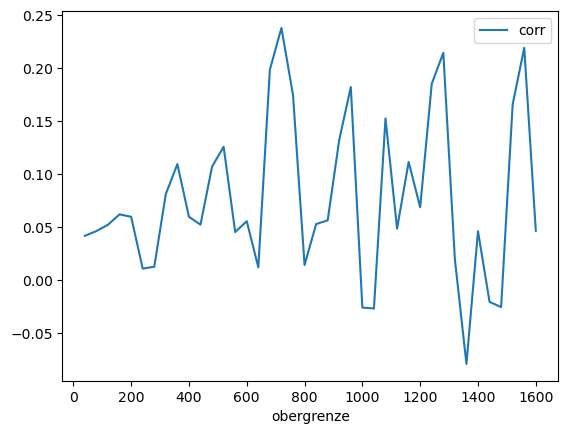

In [29]:
# Erstelle leeren DataFrame
df_korrelation_mit_CV_davor_zusammen = pd.DataFrame()
# Liste zum Sammeln der neuen Zeilen
rows = []

for i in range(40):
    schritte = 40
    darunter = schritte * i
    darüber = schritte * (i + 1)
    df_korrelation_mit_CV_davor = df_t_5_Jahre_davor_CV.query("@darunter <= CV_letzte_5_jahre <= @darüber")
    corr = df_korrelation_mit_CV_davor['pricetotal'].corr(df_korrelation_mit_CV_davor['oeffnungsrate'])
    data = {'obergrenze': darüber, 'corr': corr}
    rows.append(data)

df_korrelation_mit_CV_davor_zusammen = pd.DataFrame(rows)
df_korrelation_mit_CV_davor_zusammen.plot(x = "obergrenze", y = "corr")

<AxesSubplot:xlabel='obergrenze'>

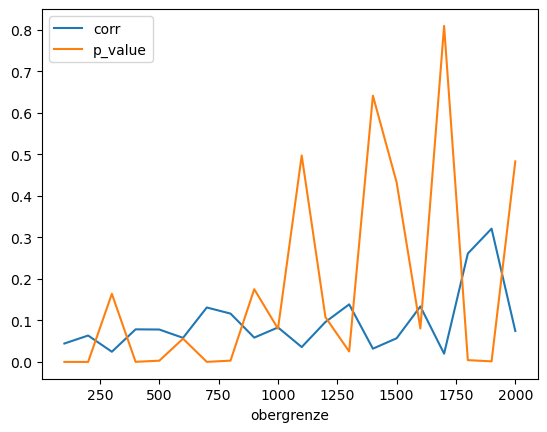

In [30]:
# Erstelle leeren DataFrame
df_korrelation_pValue_mit_CV_davor_zusammen = pd.DataFrame()
# Liste zum Sammeln der neuen Zeilen
rows = []

for i in range(20):
    schritte = 100
    darunter = schritte * i
    darüber = schritte * (i + 1)
    df_korrelation_mit_CV_davor = df_t_5_Jahre_davor_CV.query("@darunter <= CV_letzte_5_jahre <= @darüber")
    r, p_value = pearsonr(df_korrelation_mit_CV_davor['pricetotal'], df_korrelation_mit_CV_davor['oeffnungsrate'])
    data = {'obergrenze': darüber, 'corr': r, "p_value": p_value}
    rows.append(data)

df_korrelation_pValue_mit_CV_davor_zusammen = pd.DataFrame(rows)
df_korrelation_pValue_mit_CV_davor_zusammen.plot(x = "obergrenze", y = ["corr", "p_value"])

#### 8.4 Testen

array([[<AxesSubplot:title={'center':'iid'}>,
        <AxesSubplot:title={'center':'pricetotal'}>],
       [<AxesSubplot:title={'center':'oeffnungsrate'}>,
        <AxesSubplot:title={'center':'CV_letzte_5_jahre'}>]], dtype=object)

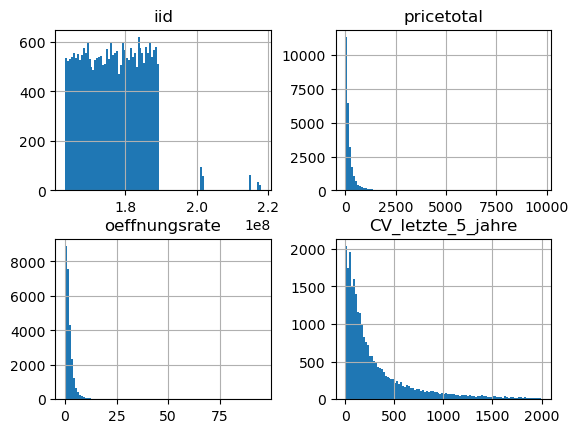

In [31]:
df_t_5_Jahre_davor_CV[df_t_5_Jahre_davor_CV["CV_letzte_5_jahre"] < 2000].hist(bins = 100)

In [32]:
df_t_5_Jahre_davor_CV["CV_letzte_5_jahre"].info()

<class 'pandas.core.series.Series'>
Int64Index: 27699 entries, 0 to 27698
Series name: CV_letzte_5_jahre
Non-Null Count  Dtype  
--------------  -----  
27699 non-null  float64
dtypes: float64(1)
memory usage: 432.8 KB


(array([1.022e+03, 1.199e+03, 1.125e+03, 9.590e+02, 1.166e+03, 8.390e+02,
        8.660e+02, 7.770e+02, 7.690e+02, 2.209e+03, 7.010e+02, 7.860e+02,
        6.750e+02, 7.640e+02, 9.060e+02, 5.600e+02, 5.890e+02, 5.340e+02,
        4.510e+02, 1.435e+03, 3.390e+02, 4.210e+02, 3.520e+02, 4.670e+02,
        5.530e+02, 3.000e+02, 3.350e+02, 2.750e+02, 2.820e+02, 1.740e+02,
        8.060e+02, 1.920e+02, 2.350e+02, 2.460e+02, 1.480e+02, 2.580e+02,
        1.890e+02, 1.330e+02, 1.220e+02, 8.100e+01, 4.980e+02, 9.500e+01,
        1.000e+02, 8.700e+01, 7.300e+01, 1.610e+02, 9.500e+01, 6.500e+01,
        5.500e+01, 5.000e+01, 3.060e+02, 3.700e+01, 5.100e+01, 6.400e+01,
        2.800e+01, 8.300e+01, 5.200e+01, 2.300e+01, 3.100e+01, 2.800e+01,
        1.910e+02, 2.000e+01, 1.900e+01, 3.400e+01, 2.300e+01, 4.800e+01,
        1.400e+01, 2.900e+01, 1.800e+01, 1.300e+01, 1.320e+02, 7.000e+00,
        1.300e+01, 2.200e+01, 1.600e+01, 3.200e+01, 1.200e+01, 2.000e+01,
        1.300e+01, 5.000e+00, 1.020e+0

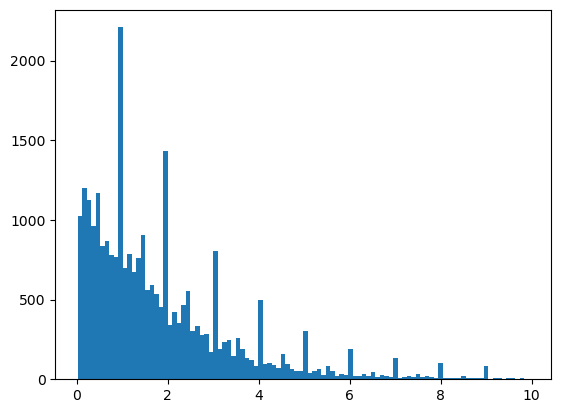

In [33]:
plt.hist(df_t_5_Jahre_davor_CV['oeffnungsrate'][df_t_5_Jahre_davor_CV['oeffnungsrate'] < 10], bins = 100)

In [34]:
x = df_t_5_Jahre_davor_CV['oeffnungsrate']
y = df_t_5_Jahre_davor_CV['pricetotal']

tau, p_value = kendalltau(x, y)
print("Kendall's tau: ", tau)
print("p-value: ", p_value)

Kendall's tau:  0.07766179970585901
p-value:  1.1722639181001213e-82
